# Demo

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [18]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [19]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


### Extract patches

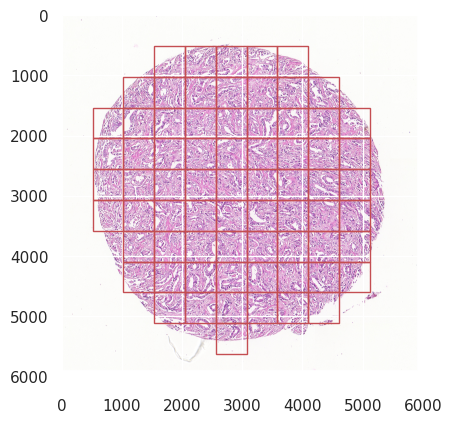

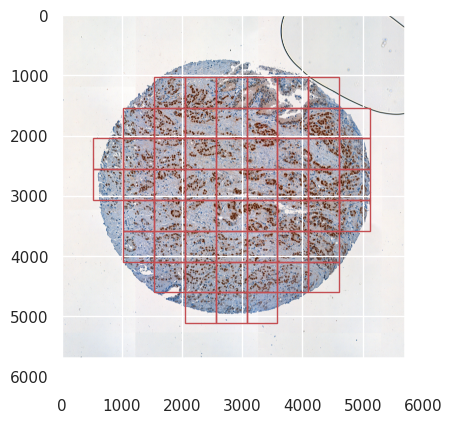

In [20]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

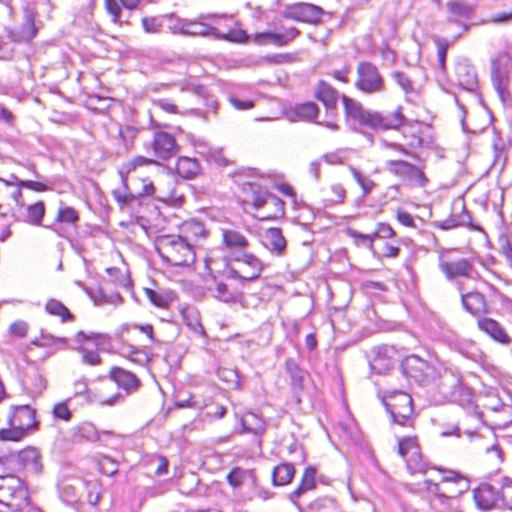

In [21]:
# Get patch to test
test_patch_src = patches_src[10]
Image.fromarray(test_patch_src)

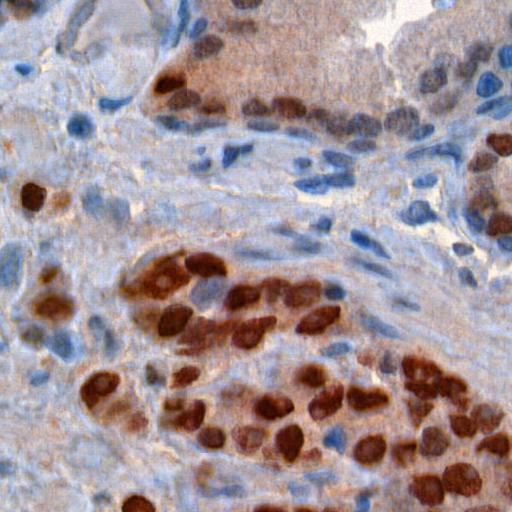

In [22]:
# Get patch to test
test_patch_dst = patches_dst[10]
Image.fromarray(test_patch_dst)

## Style extractor test

In [23]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [24]:
extractor = StyleExtractor()
style_emb = extractor(test_patch_dst_tensor)
print("out shape: ", style_emb.shape)

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


out shape:  torch.Size([1, 512, 64, 64])


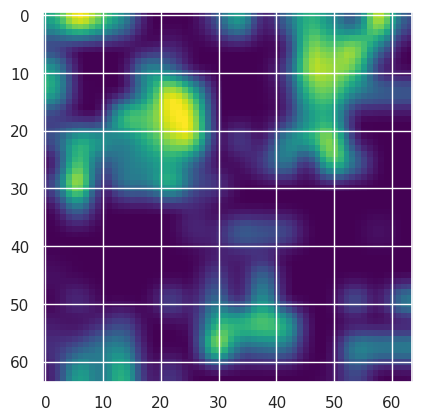

In [25]:
plt.imshow(style_emb[0, 0].detach().numpy(), cmap='viridis')

## Full VAE test

In [26]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to(device, dtype=torch.bfloat16)

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)
ut.convert_model_to_bf16(vae)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)?
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 128, 128])
Latent log_var shape: torch.Size([1, 64, 128, 128])


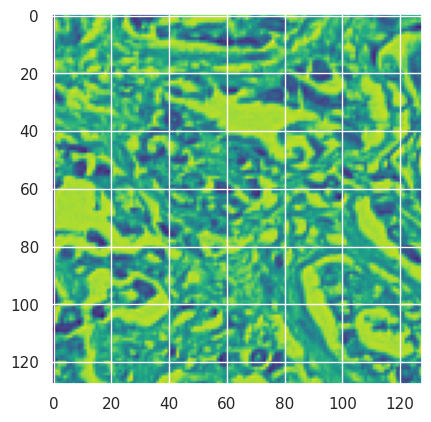

In [27]:
plt.imshow(mu[0][60].cpu().float().numpy(), cmap='viridis')

## Encoder test

In [28]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128],  # same as your encoder,
    learned=True
).to(device)
ut.convert_model_to_bf16(encoder)

encoder.eval()

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        encoded = encoder(test_patch_src_tensor)
print("Encoded shape:", encoded.shape)

Encoded shape: torch.Size([1, 64, 64, 64])


In [31]:
encoder.visualize_network(test_patch_src_tensor)

Encoded dtype: torch.bfloat16


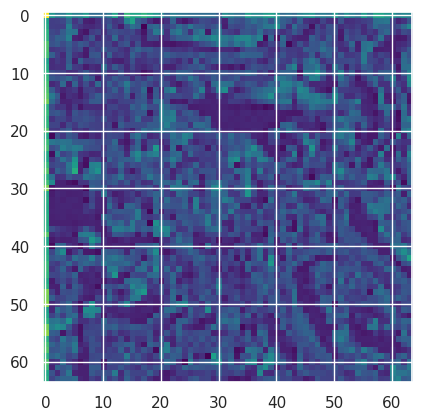

In [32]:
plt.imshow(encoded[0][0].cpu().float().numpy(),cmap='viridis')
print("Encoded dtype:", encoded.dtype)

In [48]:
class UNetModel(BaseModel):
    """
    A simplified UNet model with time and style conditioning.
    """
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=128, style_channels=512, base_channels=64, channel_mults=(1, 2, 4, 8)):
        super().__init__()

        self.attn_proj = FlashSelfAttention(z_dim=base_channels, heads=8)
        
        # Initial processing
        self.time_embed = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )
        
        self.style_channels = style_channels
        
        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        # Downsampling path
        self.downs = nn.ModuleList()
        channels = [base_channels]
        
        for i, mult in enumerate(channel_mults):
            out_channels = base_channels * mult
            self.downs.append(DownBlock(
                channels[-1], 
                out_channels,
                time_emb_dim=time_emb_dim,
                dropout=0.1
            ))
            channels.append(out_channels)
        
        # Middle blocks
        self.middle_conv1 = ConvBlock(channels[-1], channels[-1])
        self.middle_adain = SpatialAdaIN(channels[-1])
        self.middle_conv2 = ConvBlock(channels[-1], channels[-1])
        
        # Upsampling path
        self.ups = nn.ModuleList()
        for i, mult in reversed(list(enumerate(channel_mults))):
            out_channels = base_channels * mult
            self.ups.append(UpBlock(
                channels[-1], 
                out_channels,
                time_emb_dim=time_emb_dim,
                dropout=0.1
            ))
            channels.append(out_channels)
        
        # Final processing
        self.final_conv = nn.Sequential(
            ConvBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, out_channels, kernel_size=1)
        )
        
    def forward(self, x, timesteps, style):
        """
        Forward pass through the UNet.
        
        Args:
            x: Input tensor [B, C, H, W]
            timesteps: Timestep tensor [B]
            style: Style tensor [B, style_channels, H, W]
            
        Returns:
            Output tensor of same shape as input
        """
        # Time embedding
        t_emb = timestep_embedding(timesteps, self.time_embed[0].in_features)
        t_emb = self.time_embed(t_emb)
        
        # Initial processing
        h = self.init_conv(x)
        
        # Store skip connections
        skips = []
        
        # Downsampling
        for down in self.downs:
            h, skip = down(h, t_emb, style)
            skips.append(skip)
        
        # Middle blocks
        h = self.middle_conv1(h)
        h = self.middle_adain(h, style)
        h = self.middle_conv2(h)
        
        # Upsampling
        for up in self.ups:
            skip = skips.pop()
            h = up(h, skip, t_emb, style)
            # attn = FlashSelfAttention(z_dim=h.shape[1], heads=8).to('cuda')
            # ut.convert_model_to_bf16(attn)
            # h = attn(h)
        
        # Final processing
        return self.final_conv(h)

In [55]:
# Update model instantiation
model = UNetModel(
    in_channels=64,
    out_channels=64,
    time_emb_dim=128,
    style_channels=512,
    base_channels=64
).to(device)

# For the testing code, ensure the style tensor is resized if needed
x = encoded.to(device)  # Shape: [1, 64, 64, 64]
timesteps = torch.tensor([10], device=device)
style = style_emb.to(device)  # Shape: [1, 512, 32, 32] (assumed based on error)

# Print shapes for verification
print(f"Input shape: {x.shape}")
print(f"Style shape: {style.shape}")

# Manual resize if shapes don't match (you can also let the model handle this)
if style.shape[2:] != x.shape[2:]:
    print("Resizing style tensor to match input dimensions")
    style = F.interpolate(style, size=x.shape[2:], mode='bilinear', align_corners=False)

# Convert to bfloat16
x = ut.convert_to_bfloat16(x)
timesteps = ut.convert_to_bfloat16(timesteps)
style = ut.convert_to_bfloat16(style)

# Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
        output = model(x, timesteps, style)

print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 64, 64, 64])
Style shape: torch.Size([1, 512, 64, 64])
Output shape: torch.Size([1, 64, 64, 64])


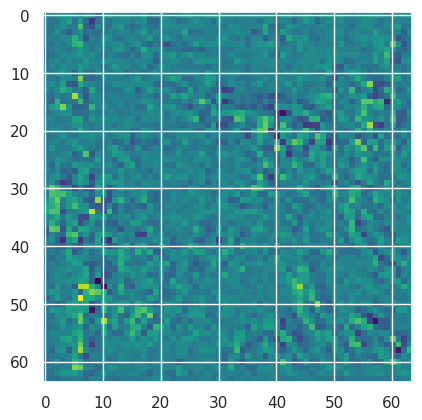

In [56]:
plt.imshow(output[0][11].cpu().float().numpy(), cmap='viridis')  # Channel 0

## U-Net model

Output dtype: torch.bfloat16


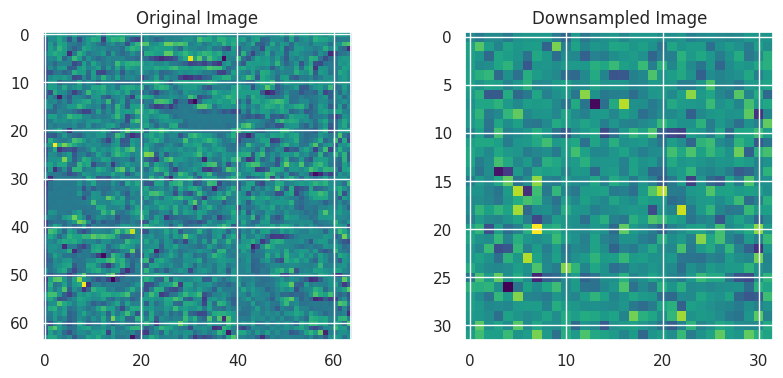

In [16]:
# Instantiate the module
downsample = Downsample(in_channels=64, use_conv=True).to('cuda')
ut.convert_model_to_bf16(downsample)

# Create a test input tensor
x = encoded

# Run the forward pass
# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        output = downsample(x)

# Visualize the output image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0][0].cpu().float().numpy(), cmap='viridis')
plt.title("Original Image")
# Visualize the original image
plt.subplot(1, 2, 2)
plt.imshow(output[0][0].cpu().float().numpy(), cmap='viridis')
plt.title("Downsampled Image")

print("Output dtype:", output.dtype)

Original shape: torch.Size([1, 64, 64, 64])
Upsampled shape: torch.Size([1, 128, 128, 128])
Output dtype: torch.bfloat16


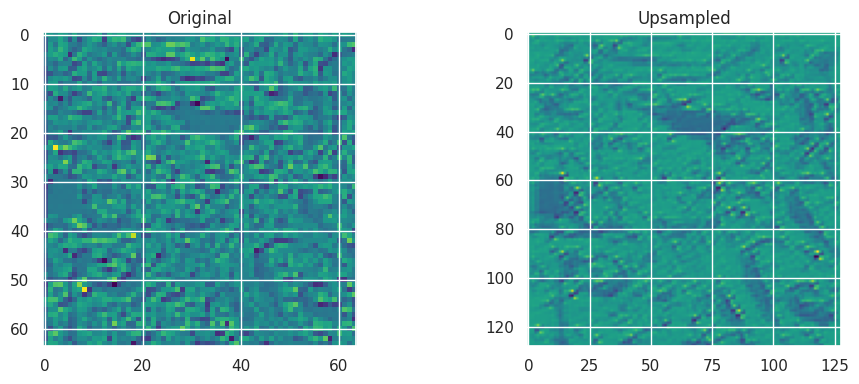

In [26]:
# Test Upsample
upsample = Upsample(in_channels=64, use_conv=True, out_channels=128).cuda()
ut.convert_model_to_bf16(upsample)
x = encoded  # Example input
x = x.to('cuda')  # Move to GPU if needed

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        x_upsampled = upsample(x)


print("Original shape:", x.shape)
print("Upsampled shape:", x_upsampled.shape)
print("Output dtype:", x_upsampled.dtype)

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].float().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_upsampled[0, 0].float().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Upsampled")
# plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define parameters for ResBlock
in_channels = 64
out_channels = 64
emb_channels = 256
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Create sample input tensor with size [1, 64, 64, 64]
x = encoded.to(device)  # Keep it float32
style = style_emb.to(device)      # (B, N_tokens, D_embed)
print(f"Input tensor shape: {x.shape}")

# Create sample timestep embedding
timestep = torch.tensor([500], device=device, dtype=torch.int64)
emb = timestep_embedding(timestep, emb_channels).to(device)  # Keep it float32
print(f"Embedding shape: {emb.shape}")

# Initialize ResBlock
resblock = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    out_channels=out_channels,
    use_scale_shift_norm=True,
    device=device,
    is_trainable=True,
).to(device)  # Keep it float32
ut.convert_model_to_bf16(resblock)  

resblock.eval()

# Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
        output = resblock(x, emb, style)

print(f"Output tensor shape: {output.shape}")

# Check output
assert output.shape == x.shape, f"Expected shape {x.shape} but got {output.shape}"

print(f"Output mean: {output.mean().item()}")
print(f"Output std: {output.std().item()}")
print(f"Output min: {output.min().item()}")
print(f"Output max: {output.max().item()}")

print("ResBlock test completed successfully!")
print("Output dtype:", output.dtype)



Using device: cuda
Input tensor shape: torch.Size([1, 64, 64, 64])
Embedding shape: torch.Size([1, 256])
Output tensor shape: torch.Size([1, 64, 64, 64])
Output mean: 20.875
Output std: 204.0
Output min: -2256.0
Output max: 8960.0
ResBlock test completed successfully!
Output dtype: torch.bfloat16


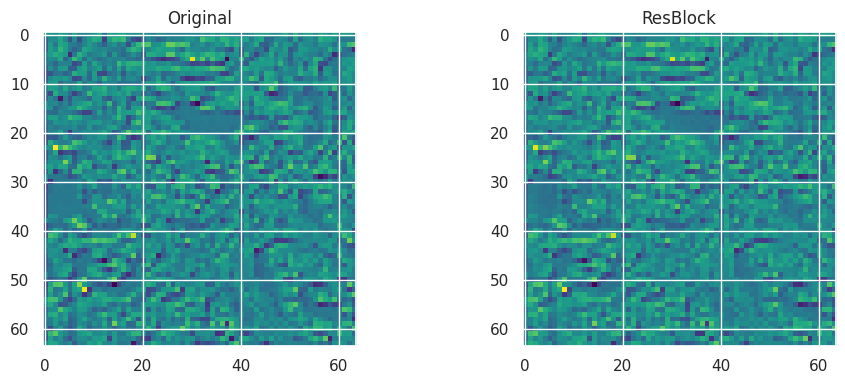

In [28]:
# Visualize output 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].float().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output[0, 0].float().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("ResBlock")
# plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:
output.shape

torch.Size([1, 64, 64, 64])

## Test  Test cross attention

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

z = encoded.to(device)       # (B, C, H, W)
# style = style_emb.to(device)      # (B, N_tokens, D_embed)

model = FlashSelfAttention(z_dim=64, heads=4).to(device)
ut.convert_model_to_bf16(model)

# Forward pass
with torch.no_grad():
    with torch.amp.autocast(enabled=True, device_type='cuda', dtype=torch.bfloat16):
        z_out = model(z)

print(f"Input z shape:     {z.shape}")
print(f"Input z dtype:     {z.dtype}")
print(f"Output z_out shape:{z_out.shape}")
print(f"Output z_out dtype:{z_out.dtype}")
print(f"Computation device: {z_out.device}")


Input z shape:     torch.Size([1, 64, 64, 64])
Input z dtype:     torch.bfloat16
Output z_out shape:torch.Size([1, 64, 64, 64])
Output z_out dtype:torch.bfloat16
Computation device: cuda:0


Text(0.5, 1.0, 'Output')

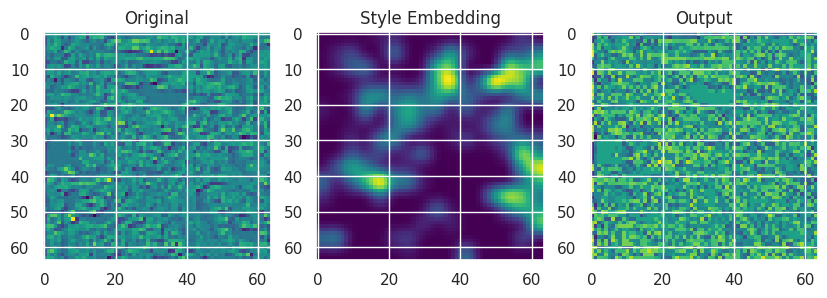

In [33]:
# visualize original and output
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(encoded[0, 0].float().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(style_emb[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Style Embedding")
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(z_out[0][0].cpu().float().numpy(), cmap='viridis')  # Channel 0
plt.title("Output")

In [34]:
# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = output.to(device)       # (B, C, H, W)
    style = style_emb.to(device)  # (B, C_style, H_style, W_style)

    model = FlashSelfAttention(z_dim=64, heads=4).to(device)

    with torch.amp.autocast(enabled=True, device_type='cuda'):
        z_out = model(z)
        z_out_vis, attention_weights = model(z, return_attention=True)

    print(f"Input z shape: {z.shape}")
    print(f"Style shape: {style.shape}")
    print(f"Output shape: {z_out.shape}")

    H, W = z.shape[2], z.shape[3]
    Utilities.visualize_attention(attention_weights, H, W, num_style_tokens=style.shape[2] * style.shape[3])


Input z shape: torch.Size([1, 64, 64, 64])
Style shape: torch.Size([1, 512, 64, 64])
Output shape: torch.Size([1, 64, 64, 64])
Visualization complete! Check 'attention_overview.png' and 'spatial_attention_maps1.png'


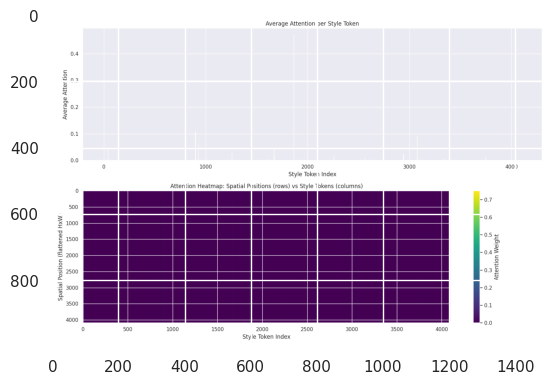

In [35]:
plt.imshow(Image.open("attention_overview.png"))

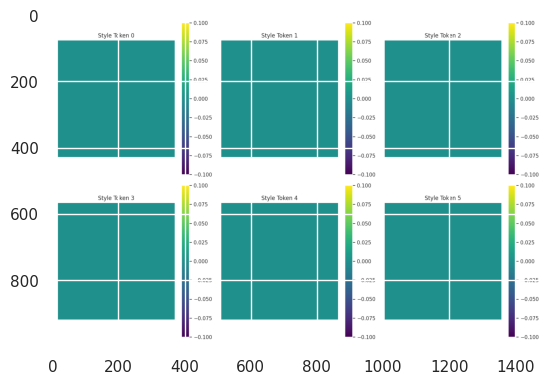

In [36]:
plt.imshow(Image.open("spatial_attention_maps.png"))

In [37]:
# Input conv → [ResBlocks (+Attention) + Downsampling] → Middle (Res+Attention+Res) → [ResBlocks (+Attention) + Upsampling] → Output conv 

Encoded shape: torch.Size([1, 64, 64, 64])


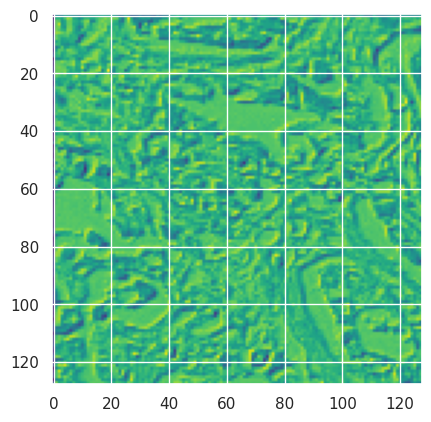

In [38]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128],  # same as your encoder,
    learned=True
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(enabled=True, device_type='cuda'):
        encoded = encoder(test_patch_src_tensor)
print("Encoded shape:", encoded.shape)


# Visualization
plt.imshow(mu[0][60].cpu().float().numpy(), cmap='viridis')